**Notebook V0 prediction du geste**
- Mediapipe pour obtenir les coordonnées de la main à partir des images shifumi (réelles + synthèses)
- Classifier Kmeans et KNN pour prédire le geste

**I. Mediapipe hand landmarks detection**

**1. Dataset**

In [1]:
!pip install mediapipe opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 998.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
import mediapipe as mp
import cv2
import numpy as np
import uuid
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random

In [13]:
drawingModule = mp.solutions.drawing_utils
handsModule = mp.solutions.hands
hands = handsModule.Hands(static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.8)


mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False,
                       max_num_hands=1,
                        min_detection_confidence=0.8)

**II. Classifier KNN**

**1. Entrainement du modèle**

In [10]:
# récuperer le fichier csv
import numpy as np
import csv
data_from_csv = []
labels_from_csv = []
path_from_csv = []
with open('/content/landmarks.csv', newline='') as file:
    reader = csv.reader(file)
    # skip the header
    next(reader)
    for row in reader:
        #convert to float
        data_from_csv.append(np.array(row[3][1:-1].split()).astype(float))
        labels_from_csv.append(row[0])
        path_from_csv.append(row[2])

data_from_csv = np.array(data_from_csv)
labels_from_csv = np.array(labels_from_csv).astype(int)
path_from_csv = np.array(path_from_csv)


## Ces fonctions définient dans la section précédente sont utiles pour la suite

def landmarkPoint(image, path=True):
    if path:
        image = cv2.imread(image)
    # image = random_rotation(image)
    # image = random_flip(image)
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if results.multi_hand_landmarks != None:
        for handLandmarks in results.multi_hand_landmarks:
            return handLandmarks


def landmarkFormat(handLandmarks):

    def normalize(landmarks):
        x = np.array([landmark.x for landmark in landmarks])
        y = np.array([landmark.y for landmark in landmarks])
        z = np.array([landmark.z for landmark in landmarks])
        x = (x - np.min(x)) / (np.max(x) - np.min(x))
        y = (y - np.min(y)) / (np.max(y) - np.min(y))
        z = (z - np.min(z)) / (np.max(z) - np.min(z))
        return (x, y, z)

    def cartesian_to_polar(landmarks):
        x, y, z = normalize(landmarks)
        r = np.sqrt(x**2 + y**2 + z**2)
        theta = np.where(r != 0, np.arccos(z/r), 0)
        phi = np.where(x != 0, np.arctan2(y, x), 0)
        return np.array([r, theta, phi]).T

    return cartesian_to_polar(handLandmarks.landmark)


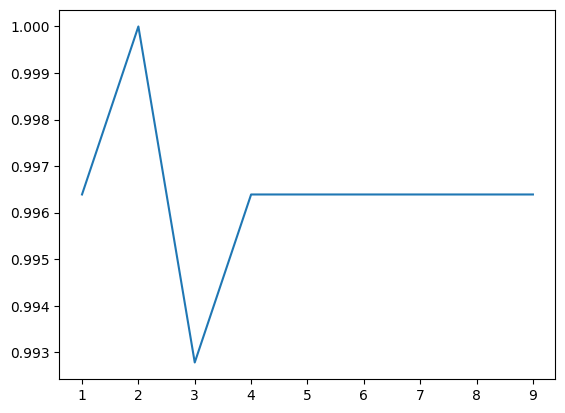

In [7]:
#k nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# df = data
# df_labels = labels_data

df = data_from_csv
df_labels = labels_from_csv

# cross validation to choose the best k
X_train1, X_test, y_train1, y_test = train_test_split(df, df_labels, test_size=0.2, random_state=42)
X_train2, X_validation, y_train2, y_validation = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42)
scores = []
for k in range(1, 10):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train2, y_train2)
    y_pred = model.predict(X_validation)
    accuracy = accuracy_score(y_validation, y_pred)
    scores.append(accuracy)
plt.plot(range(1, 10), scores)


In [ ]:
import sklearn
print(sklearn.__version__)

1.2.2


In [8]:
model = KNeighborsClassifier(n_neighbors=2) #metric= 'euclidean' or 'cosine
model.fit(X_train1, y_train1)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9971098265895953


In [ ]:
from google.colab.patches import cv2_imshow

**2. test en temps réel**

In [ ]:
# Ouverture du flux vidéo
import cv2
import numpy as np

cap = cv2.VideoCapture(0)

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False,
                       max_num_hands=1,
                        min_detection_confidence=0.8)

while cap.isOpened():
    success, image = cap.read()
    if not success:
        print("Ignoring empty camera frame.")
        continue

    # Conversion de l'image de BGR à RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image)

    # Dessin des landmarks de la main
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            mp.solutions.drawing_utils.draw_landmarks(
                image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Transformation et prédiction du cluster
            x0, y0, z0 = hand_landmarks.landmark[0].x, hand_landmarks.landmark[0].y, hand_landmarks.landmark[0].z
            transformed_landmarks = landmarkFormat(hand_landmarks)
            transformed_landmarks_flat = np.ravel(transformed_landmarks).reshape(1, -1)
            cluster_label = model.predict(transformed_landmarks_flat)

            # Affichage du cluster sur l'image
            if cluster_label == 0:
                cv2.putText(image, 'Feuille', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
            elif cluster_label == 1:
                cv2.putText(image, 'Pierre', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
            elif cluster_label == 2:
                cv2.putText(image, 'Ciseaux', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
            else:
                cv2.putText(image, 'Inconnu', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
            # Afficher la plus proche distance
            nearest_neighbors = model.kneighbors(transformed_landmarks_flat, 5)
            mean_distance = np.mean(nearest_neighbors[0][0])
            # cv2.putText(image, 'Distance: {:.2f}'.format(mean_distance), (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

            #cv2.putText(image, 'Cluster: {}'.format(cluster_label), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    # Affichage de l'image résultante
    # cv2.imshow('MediaPipe Hands', image)
    ### spécifiqua à Colab

    cv2_imshow(image)
    print('test')


    # Arrêt avec la touche 'q'
    if cv2.waitKey(5) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


## Test sur nos données

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
dataset_path = '/content/drive/MyDrive/Centrale/3A/Projet 3A/dataset_centrale'

print(dataset_path)
labels = []
for i in os.listdir(dataset_path):
  if os.path.isdir(os.path.join(dataset_path, i)):
    labels.append(i)
print(labels)


/content/drive/MyDrive/Centrale/3A/Projet 3A/dataset_centrale
['rock', 'paper', 'scissors', 'augmented']


In [18]:
dico = {
  'rock': 1,
  'paper': 0,
  'scissors': 2
}

y_test = []
y_pred = []
for label in labels:
  if label != 'augmented' :
    label_dir = os.path.join(dataset_path, label)
    # STEP 3: Load the input image.
    example_filenames = os.listdir(label_dir)
    for i in range(len(example_filenames)):
      image_path = os.path.join(label_dir, example_filenames[i])
      image = cv2.imread(image_path)

      # STEP 4: Recognize gestures in the input image.
      results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
          mp.solutions.drawing_utils.draw_landmarks(
              image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
          transformed_landmarks = landmarkFormat(hand_landmarks)
          transformed_landmarks_flat = np.ravel(transformed_landmarks).reshape(1, -1)
          y_pred.append(model.predict(transformed_landmarks_flat)[0])
          y_test.append(dico[label])

print(y_pred)
print(y_test)

# display_batch_of_images_with_gestures_and_hand_landmarks(images, results)

[1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 2, 2, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 1, 0, 2, 2, 2, 1, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [20]:
accuracy = sum([1 for i in range(len(y_test)) if y_test[i] == y_pred[i]])/len(y_test)
print(accuracy)

0.8223495702005731


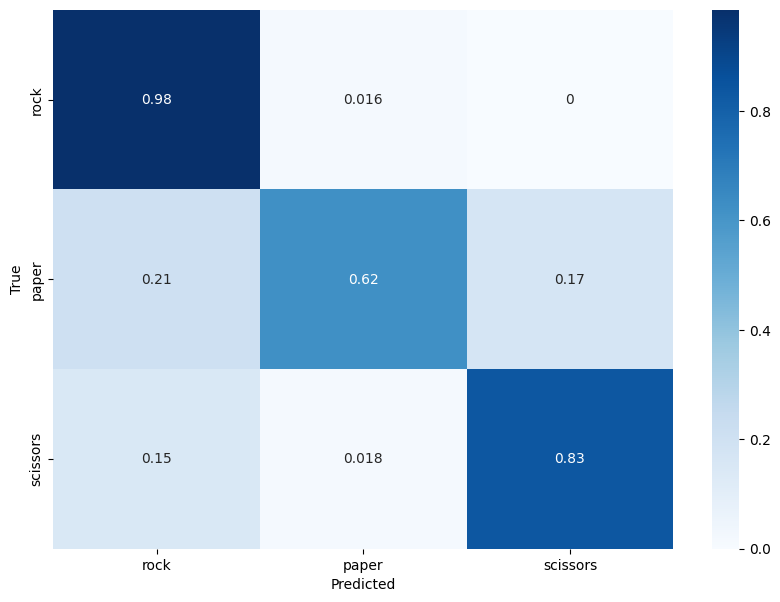

In [19]:
# confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

labels = ['rock', 'paper', 'scissors']

cm = confusion_matrix(y_test, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
